### Import TensorFlow and other libraries

# Dataset Description
The dataset consists of all 70k REAL faces from the Flickr dataset collected by Nvidia, as well as 70k fake faces sampled from the 1 Million FAKE faces (generated by StyleGAN) that was provided by Bojan.

In this dataset, I convenient combined both dataset, resized all the images into 256px, and split the data into train, validation and test set. I also included some CSV files for convenience.

**Dataset**: https://www.kaggle.com/xhlulu/140k-real-and-fake-faces

In [1]:
!pip install pydot

In [2]:
# !pip install pydotplus

In [3]:
import os, datetime

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from PIL import Image
import matplotlib.pyplot as plt

# import pydotplus
import pydot

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
base_dir = "../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/"
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
valid_dir = os.path.join(base_dir, 'valid')

### Image preparation for CNN Image Classifier

In [6]:
train_datagen = ImageDataGenerator( rescale = 1.0/255.,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
test_datagen = ImageDataGenerator( rescale = 1.0/255. )
valid_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [7]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=100, class_mode='binary', target_size=(150, 150))

validation_generator = valid_datagen.flow_from_directory(valid_dir, batch_size=100, class_mode='binary', target_size=(150, 150))

test_generator = test_datagen.flow_from_directory(test_dir, batch_size=100, class_mode='binary', target_size=(150, 150))

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [8]:
print(train_generator.class_indices)

{'fake': 0, 'real': 1}


### Visualize the data

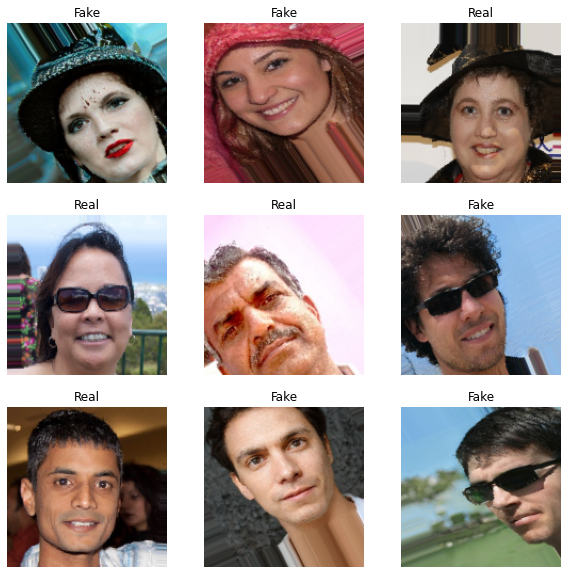

In [9]:
plt.figure(figsize=(10, 10))
for i in range(9):
    img, label = train_generator.next()
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img[0])
    if(label[0] == 0.0):
        plt.title("Fake")
    else:
        plt.title("Real")
    plt.axis("off")

## Model architecture

In [10]:
model = tf.keras.models.Sequential(
    [
     tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(150, 150, 3)),
     tf.keras.layers.MaxPooling2D(2,2),

     tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),

     tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
     tf.keras.layers.MaxPooling2D(2,2),

     tf.keras.layers.Flatten(),

     tf.keras.layers.Dense(1064, activation='relu'),
#      tf.keras.layers.Dense(2, activation='softmax')
     tf.keras.layers.Dense(2)
    ]
)

## Visualizing network architectures

In [11]:
# tf.keras.utils.pydot = pydot

In [12]:
# plot_model(model, to_file='model.png', show_shapes=True)

#### Model summary

View all the layers of the network using the model's summary method:

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0

#### Compile and train the model

In [14]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics = ['accuracy'])

In [15]:
%%time
history = model.fit(train_generator, validation_data = validation_generator, epochs = 10, validation_steps = 100, verbose=1)

Epoch 1/10
1000/1000 [==============================] - 1103s 1s/step - loss: 0.7200 - accuracy: 0.5358 - val_loss: 0.6313 - val_accuracy: 0.6466
Epoch 2/10
1000/1000 [==============================] - 746s 745ms/step - loss: 0.6444 - accuracy: 0.6254 - val_loss: 0.5695 - val_accuracy: 0.7021
Epoch 3/10
1000/1000 [==============================] - 731s 731ms/step - loss: 0.5904 - accuracy: 0.6870 - val_loss: 0.5698 - val_accuracy: 0.7002
Epoch 4/10
1000/1000 [==============================] - 739s 739ms/step - loss: 0.5396 - accuracy: 0.7318 - val_loss: 0.4982 - val_accuracy: 0.7548
Epoch 5/10
1000/1000 [==============================] - 731s 730ms/step - loss: 0.5074 - accuracy: 0.7537 - val_loss: 0.4594 - val_accuracy: 0.7824
Epoch 6/10
1000/1000 [==============================] - 761s 761ms/step - loss: 0.4846 - accuracy: 0.7658 - val_loss: 0.4463 - val_accuracy: 0.7897
Epoch 7/10
1000/1000 [==============================] - 757s 757ms/step - loss: 0.4614 - accuracy: 0.7842 - val_lo

In [16]:
model.save("./model.h5")

#### Visualize training results

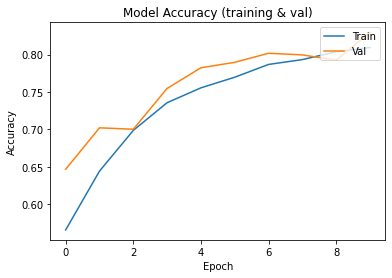

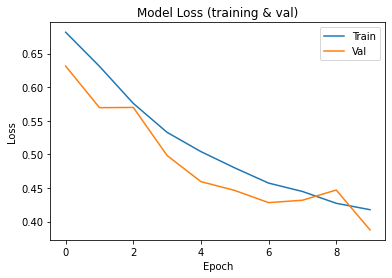

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy (training & val)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss (training & val)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

### Evaluate the model on the test data via evaluate():

In [18]:
test_loss, test_acc = model.evaluate(test_generator)

200/200 [==============================] - 183s 915ms/step - loss: 0.3815 - accuracy: 0.8311


In [19]:
test_acc

0.8310999870300293

In [20]:
test_loss

0.3814851641654968

In [21]:
test_generator.class_indices

{'fake': 0, 'real': 1}

In [22]:
class_names = list(test_generator.class_indices.keys())

In [23]:
class_names

['fake', 'real']

#### Predict on new data

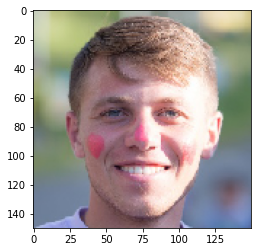

In [24]:
import numpy as np
from keras.preprocessing import image

test_image = image.load_img('../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00056.jpg', target_size=(150, 150, 3))
plt.imshow(test_image)

test_image_arr = image.img_to_array(test_image)
test_image_arr = np.expand_dims(test_image, axis=0)


Logits return the raw value for out prediction. So we applied softmax to normalize the values [0, 1]

In [25]:
logits = model.predict(test_image_arr)
print(logits)
predictions = tf.nn.softmax(logits).numpy()
print(predictions)

[[-319.31586  267.40878]]
[[0. 1.]]


<!-- TODO 
predicted_class_raw = np.argmax(logits) -->

This image most likely belongs to real with a 100.00 percent confidence.
100.0


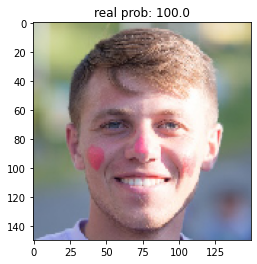

In [26]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(predictions)], 100 * np.max(predictions))
)

print(100 * np.max(predictions))

if np.argmax(predictions) == 0:
    title = "fake prob: " + str(100 * np.max(predictions))
else:
    title = "real prob: " + str(100 * np.max(predictions))
    
plt.title(title)
plt.imshow(test_image)